# Plot model fits for PEERS simulation analysis

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy import stats
from psifr import fr
from mindstorm import statplot
from cymr import cmr
from dcmr import framework
from dcmr import figures

res_dir = Path(os.environ['PEERS_RESULTS'])
fit_dir = Path(os.environ['PEERS_FITS'])
fig_dir = Path(os.environ['PEERS_FIGURES']) / "sim2"
fig_dir.mkdir(exist_ok=True)

data_file = res_dir / 'peers_notask.csv'
patterns_file = res_dir / 'peers_patterns.hdf5'
figures.set_style()

## Read observed and simulated data

In [2]:
patterns = cmr.load_patterns(patterns_file)
rsm = patterns['similarity']['use']

In [3]:
models = [
    'cmrs_fcf-loc-use',
    'cmrs_fcf-loc-use_sl-B_enc-B_rec',
    'cmrs_fcf-loc-use_sl-B_enc-B_rec_fix-B_rec_use1',
    'cmrs_fcf-loc-use_sl-B_enc-B_rec_fix-B_enc_use1',
    'cmrs_fcf-loc-use_sl-B_enc-B_rec_fix-B_enc_use1-B_rec_use1',
    'cmrs_fcf-loc_ff-use',
]
model_names = [
    'DCMR',
    'DCMR-Variable',
    'DCMR-Restricted',
    'DCMR-NoEncSemDrift',
    'DCMR-NoSemDrift',
    'CMR-MP16',
]
data = framework.read_model_sims(data_file, fit_dir, models, model_names)
data['item_index'] = fr.pool_index(data['item'], patterns['items'])

In [4]:
# for speed, omit simulation replications; comment out for final
# data = data.loc[data['list'] <= 48]

## Set colors

In [5]:
curve = sns.color_palette(
    'ch:rot=-.5, light=.6, dark=.3, gamma=1', n_colors=len(models)
)
curve.insert(len(models), (.3, .3, .3))
curve

[(0.44163916703794076, 0.6914342033666265, 0.5414714890673176),
 (0.36749205871815316, 0.6342031153097065, 0.5158983064700672),
 (0.2998901305215498, 0.5667288354267224, 0.49176489739609264),
 (0.2478315217304068, 0.49799749188127057, 0.4676337633478139),
 (0.2060013782030815, 0.42511545174597526, 0.4378697085461622),
 (0.17051215858853222, 0.344636926092434, 0.3959064384004337),
 (0.3, 0.3, 0.3)]

In [6]:
dark = sns.color_palette(
    'ch:rot=-.5, light=.7, dark=.3, gamma=.6', n_colors=len(models)
)
dark.insert(len(models), (.6, .6, .6))
dark

[(0.725301473503126, 0.8645990769601404, 0.7363315007817791),
 (0.6301880172954943, 0.821579705309864, 0.6961110603935465),
 (0.5427076486246496, 0.771710695114872, 0.6701319979849277),
 (0.4593472088732401, 0.7071961533016182, 0.6504149251866279),
 (0.39110594148072964, 0.6324777802536509, 0.6312990119406077),
 (0.33145894574681245, 0.5393097642399239, 0.6005096167923277),
 (0.6, 0.6, 0.6)]

In [7]:
light = sns.color_palette(
    'ch:rot=-.5, light=.7, dark=.3, gamma=.2', n_colors=len(models)
)
light.insert(len(models), (.85, .85, .85))
light

[(0.8973525746116884, 0.9546730560357413, 0.901891392639006),
 (0.8554842374828773, 0.9402471605271036, 0.8846800185898492),
 (0.8129470070784969, 0.9227303114779495, 0.8740338194511824),
 (0.7674586562158442, 0.8982475055200396, 0.868284289399163),
 (0.7249604802029561, 0.866877165046262, 0.8661840979012467),
 (0.6820851323976215, 0.8225675908928259, 0.8639314200489312),
 (0.85, 0.85, 0.85)]

In [8]:
opt = {'height': 4, 'aspect': 1, 'palette': curve}

In [9]:
drw = data.groupby('source').apply(
    fr.distance_rank_window_asym, 
    'item_index', 
    1 - rsm, 
)

In [10]:
sources = model_names + ['Data']
drw = drw.reindex(sources, axis='index', level=0)
drw

subject     n      asym
source                             
DCMR   0         63  8952  0.000364
       1         64  7245 -0.006159
       2         65  6685 -0.013807
       3         66  8361  0.002432
       4         67  8873 -0.005196
...             ...   ...       ...
Data   121      240   115  0.015773
       122      241   125 -0.050803
       123      242    81  0.010172
       124      243   107 -0.025263
       125      244   136 -0.023246

[882 rows x 3 columns]

In [11]:
drw.loc['Data', 'asym'].mean()

-0.00728196345437044

In [12]:
pg.ttest(drw.loc['Data', 'asym'].to_numpy(), 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.100661,125,two-sided,0.03768,"[-0.01, -0.0]",0.187142,0.827,0.549583


## Analyze distance rank asymmetry

,n
count,126.000000
mean,119.309524
std,32.822057
min,44.000000
25%,101.000000
50%,118.500000
75%,138.750000
max,203.000000


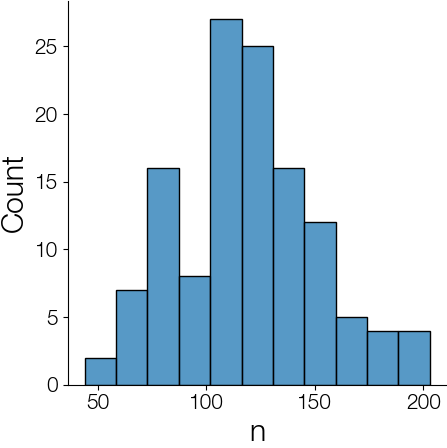

In [13]:
sources = model_names + ['Data']
drw = drw.reindex(sources, axis='index', level=0)
n = drw.loc['Data'].groupby('subject')[['n']].mean()
sns.displot(data=n, x='n')
n.describe()

In [14]:
drw.loc['Data'].groupby('subject')[['n']].sum().agg(['mean', 'sem'])

,n
mean,119.309524
sem,2.924021


In [15]:
diff = drw.copy()
diff['rank'] = diff['asym']

LINO NOT subset; don't know how to subset; dropped


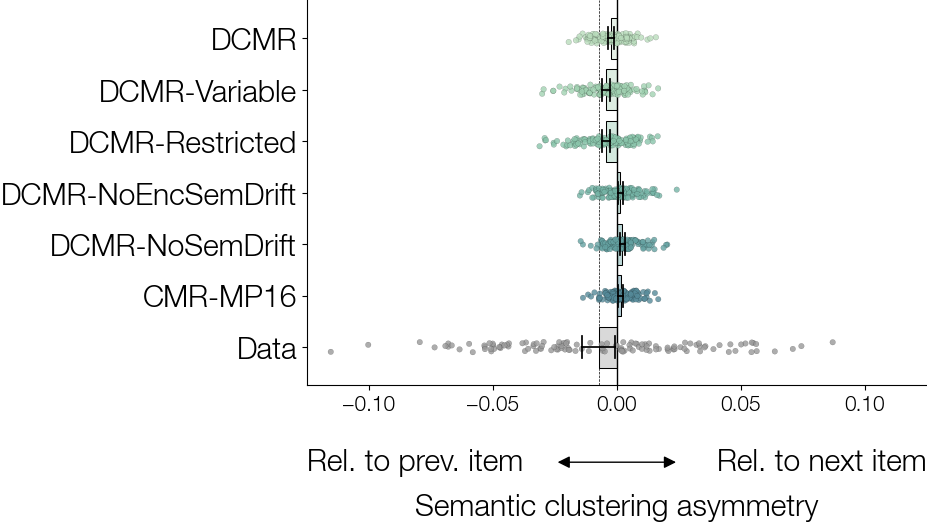

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))
figures.plot_dist_rank_asym(diff, dark, light, ax=ax)
ax.set(xlim=(-0.125, 0.125))
None
fig.savefig(fig_dir / "dist_rank_asym.pdf")

In [17]:
p = diff['asym'].unstack('source')
pd.DataFrame({c: pg.ttest(p[c], 0).iloc[0] for c in p.columns})

,DCMR,DCMR-Variable,DCMR-Restricted,DCMR-NoEncSemDrift,DCMR-NoSemDrift,CMR-MP16,Data
T,-4.295555,-5.379066,-4.859472,2.347868,3.879039,3.072209,-2.100661
dof,125,125,125,125,125,125,125
alternative,two-sided,two-sided,two-sided,two-sided,two-sided,two-sided,two-sided
p-val,0.000035,0.0,0.000003,0.020452,0.000169,0.002608,0.03768
CI95%,"[-0.0, -0.0]","[-0.01, -0.0]","[-0.01, -0.0]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]","[-0.01, -0.0]"
cohen-d,0.382678,0.479205,0.432916,0.209165,0.345572,0.273694,0.187142
BF10,453.722,3.432e+04,3966.393,1.387,104.082,8.513,0.827
power,0.989343,0.999634,0.997894,0.644256,0.970561,0.861826,0.549583


In [18]:
test = pg.ttest(p['Data'], 0)
test

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.100661,125,two-sided,0.03768,"[-0.01, -0.0]",0.187142,0.827,0.549583


In [19]:
x = p['Data']
df = test['dof'].iloc[0]
m = np.mean(x)
sem = np.std(x) / np.sqrt(len(x) - 1)
lb = m + sem * stats.t.ppf(0.05 / 2, df)
ub = m + sem * stats.t.ppf(1 - 0.05 / 2, df)
print(f'{m=} {sem=} {lb=} {ub=}')

m=-0.00728196345437044 sem=0.0034665099923176937 lb=-0.01414261695564107 ub=-0.00042130995309981167


## Serial position effects

In [20]:
spc = data.groupby('source').apply(fr.spc)

LINO NOT subset; don't know how to subset; dropped


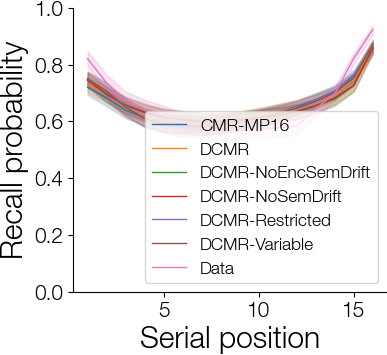

In [21]:
g = fr.plot_spc(spc, hue='source', height=4, aspect=1.1)
g.axes[0, 0].legend(fontsize='x-small')
g.savefig(fig_dir / 'spc_comp.pdf')

LINO NOT subset; don't know how to subset; dropped
LINO NOT subset; don't know how to subset; dropped


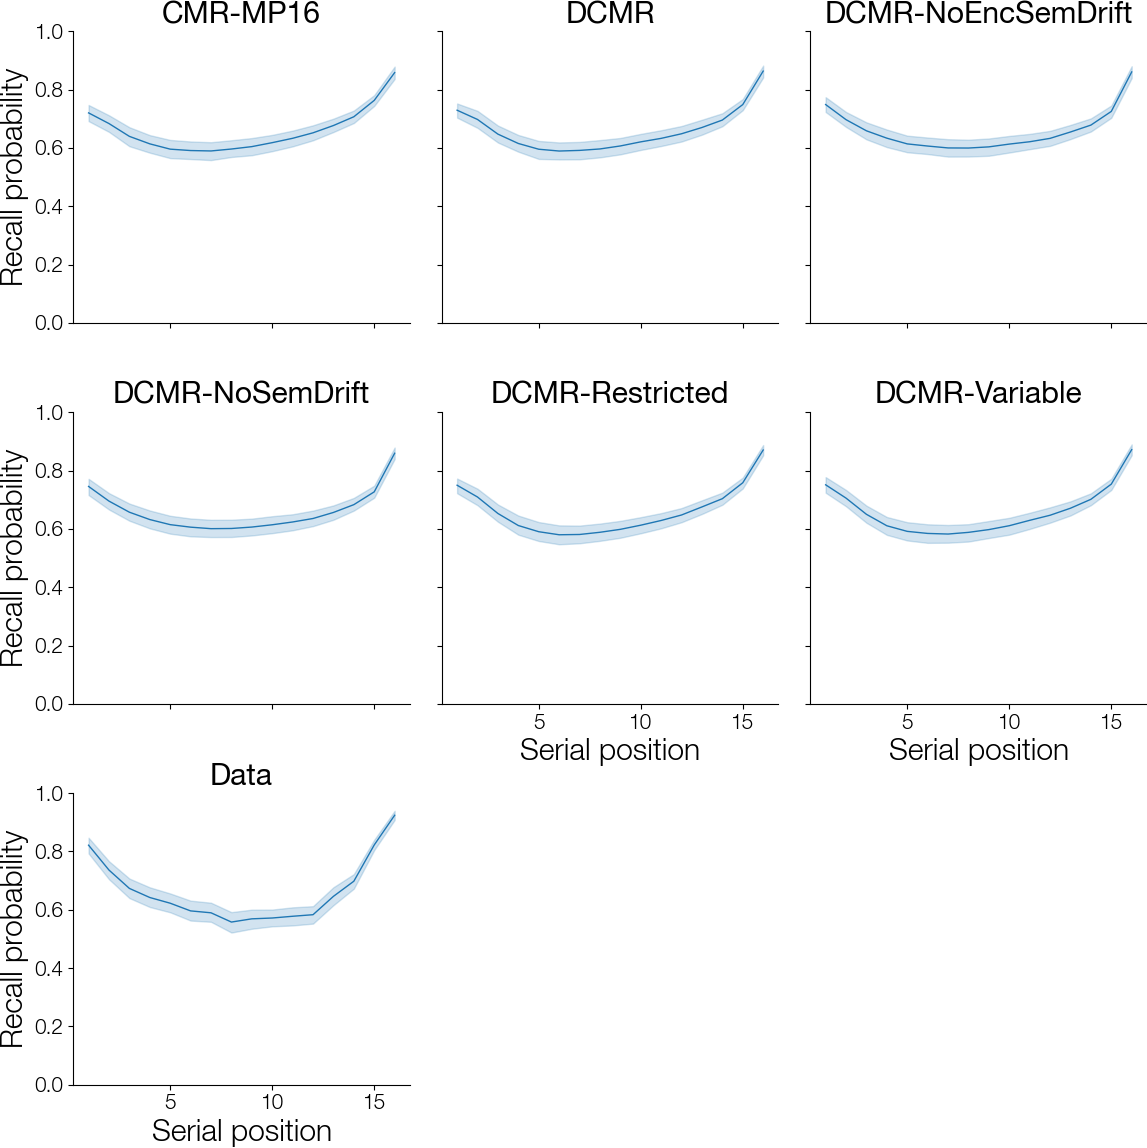

In [46]:
g = fr.plot_spc(spc, col='source', col_wrap=3, height=4, aspect=1)
g.set_titles('{col_name}')
g.savefig(fig_dir / 'spc.pdf');

In [22]:
pnr = data.groupby('source').apply(fr.pnr)

LINO NOT subset; don't know how to subset; dropped
LINO NOT subset; don't know how to subset; dropped


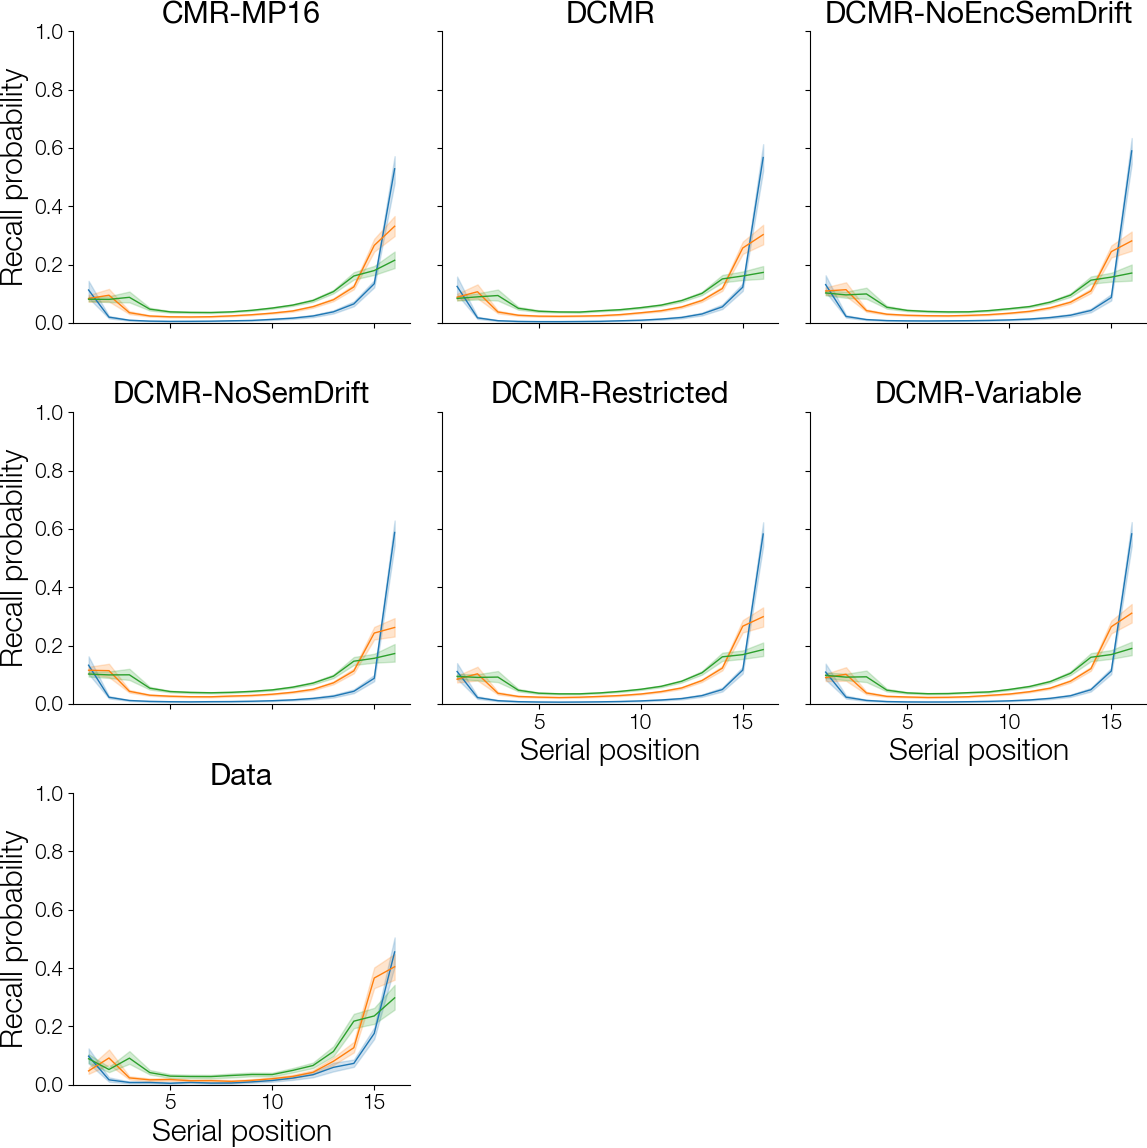

In [45]:
g = fr.plot_spc(
    pnr.query('output <= 3'), hue='output', col='source', col_wrap=3, height=4, aspect=1
)
g.set_titles('{col_name}')
g.savefig(fig_dir / 'pnr.pdf');

In [24]:
lag_crp = data.groupby('source').apply(fr.lag_crp)

LINO NOT subset; don't know how to subset; dropped
LINO NOT subset; don't know how to subset; dropped


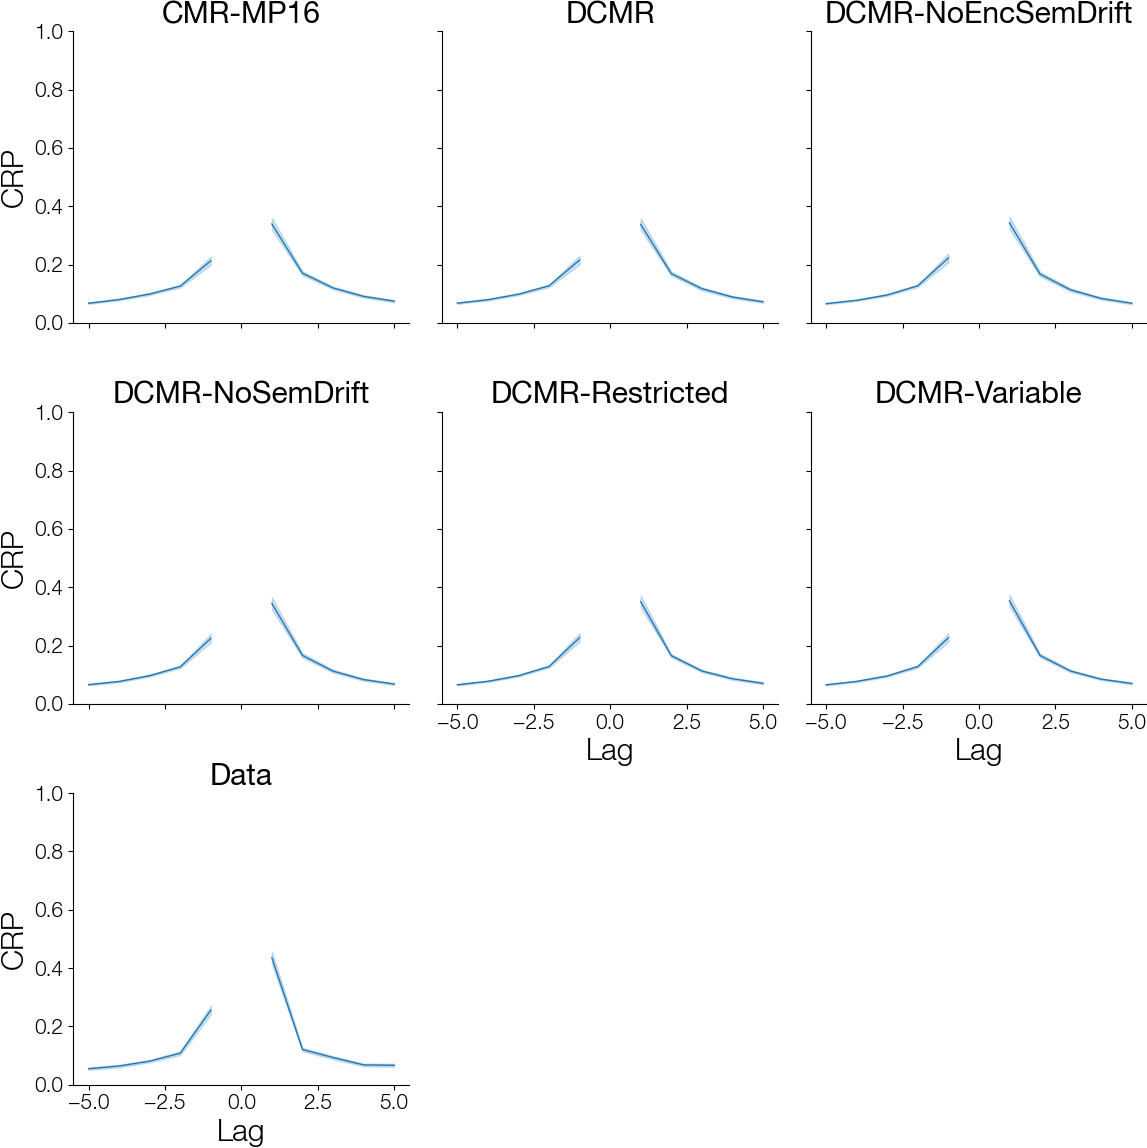

In [44]:
g = fr.plot_lag_crp(lag_crp, col='source', col_wrap=3, height=4, aspect=1)
g.set_titles('{col_name}')
g.savefig(fig_dir / 'crp.pdf')

## Clustering measures

In [26]:
lag_rank_within = data.groupby('source').apply(fr.lag_rank)

/Users/nmorton/PycharmProjects/dcmr/.venv/lib/python3.10/site-packages/mindstorm/statplot.py:188: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=data, x=x, y=y, hue=hue, ax=ax, **point_prop, **kwargs)
/Users/nmorton/PycharmProjects/dcmr/.venv/lib/python3.10/site-packages/mindstorm/statplot.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=x, y=y, hue=hue, ax=ax, **bar_prop, **kwargs)
/Users/nmorton/PycharmProjects/dcmr/.venv/lib/python3.10/site-packages/mindstorm/statplot.py:204: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'k'}` instead.

  sns.barplot(data=data, x=x, y=y, hue=hue, ax=ax, **bar_prop

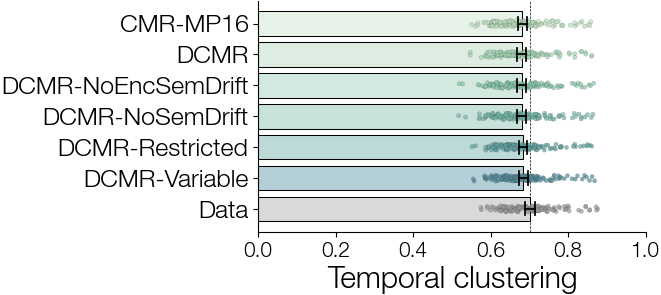

In [27]:
fig, ax = plt.subplots(figsize=(5, 3))
statplot.plot_swarm_bar(
    lag_rank_within,
    y='source',
    x='rank',
    dark=dark,
    light=light,
    point_kind='strip',
    ax=ax,
)
ax.tick_params(axis='x', labelsize='small')
ax.tick_params(axis='y', labelsize='medium')
m = lag_rank_within.loc['Data', 'rank'].mean()
ax.axline([m, 0], slope=np.inf, linestyle='--', linewidth=.5, color='k')
ax.set(xlim=(0, 1), xlabel='Temporal clustering', ylabel='');
fig.savefig(fig_dir / 'comp_lag_rank.pdf')

In [28]:
use_rank = data.groupby('source').apply(fr.distance_rank, 'item_index', 1 - rsm)

/Users/nmorton/PycharmProjects/dcmr/.venv/lib/python3.10/site-packages/mindstorm/statplot.py:188: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=data, x=x, y=y, hue=hue, ax=ax, **point_prop, **kwargs)
/Users/nmorton/PycharmProjects/dcmr/.venv/lib/python3.10/site-packages/mindstorm/statplot.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=x, y=y, hue=hue, ax=ax, **bar_prop, **kwargs)
/Users/nmorton/PycharmProjects/dcmr/.venv/lib/python3.10/site-packages/mindstorm/statplot.py:204: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'k'}` instead.

  sns.barplot(data=data, x=x, y=y, hue=hue, ax=ax, **bar_prop

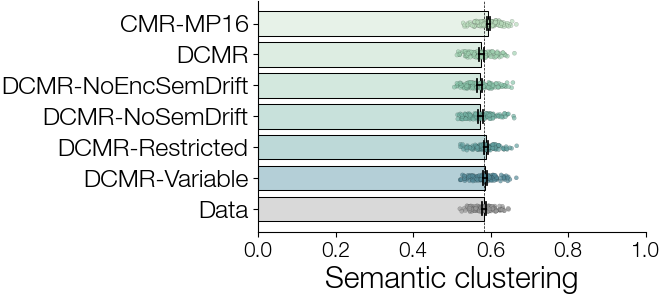

In [29]:
fig, ax = plt.subplots(figsize=(5, 3))
statplot.plot_swarm_bar(
    use_rank,
    y='source',
    x='rank',
    dark=dark,
    light=light,
    point_kind='strip',
    ax=ax,
)
ax.tick_params(axis='x', labelsize='small')
ax.tick_params(axis='y', labelsize='medium')
m = use_rank.loc['Data', 'rank'].mean()
ax.axline([m, 0], slope=np.inf, linestyle='--', linewidth=.5, color='k')
ax.set(xlim=(0, 1), xlabel='Semantic clustering', ylabel='');
fig.savefig(fig_dir / 'comp_use_rank.pdf')

## Shifted distance rank

In [30]:
distances = 1 - rsm
max_shift = 3
dist_rank = data.groupby('source').apply(
    fr.distance_rank_shifted, 
    'item_index', 
    distances, 
    max_shift, 
)

LINO NOT subset; don't know how to subset; dropped


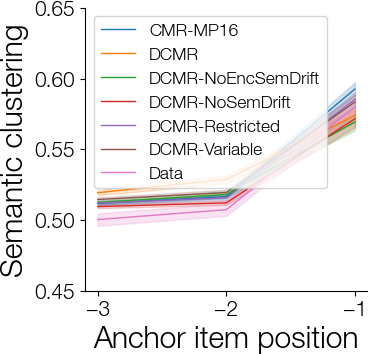

In [31]:
g = sns.relplot(
    data=dist_rank.reset_index(), 
    x='shift', 
    y='rank', 
    hue='source', 
    kind='line', 
    height=4,
    aspect=1.2,
)
ax = g.axes[0, 0]
g._legend.remove()
g.set(ylim=[.45, .65], ylabel='Semantic clustering', xlabel='Anchor item position')
ax.legend(fontsize='x-small')
g.savefig(fig_dir / 'use_rank_shifted_comp.pdf')

In [32]:
subs = dist_rank.loc['Data']
shift_mat = pd.pivot(
    subs.reset_index(), index='subject', columns='shift', values='rank'
)
pg.ttest(shift_mat[-2], shift_mat[-3])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.225321,250,two-sided,0.026952,"[0.0, 0.01]",0.280364,1.421,0.601349


In [33]:
subs = dist_rank.loc['DCMR']
shift_mat = pd.pivot(
    subs.reset_index(), index='subject', columns='shift', values='rank'
)
pg.ttest(shift_mat[-2], shift_mat[-3])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,5.521793,250,two-sided,8.395849e-08,"[0.01, 0.01]",0.695681,1.372e+05,0.9998


In [34]:
subs = dist_rank.loc['DCMR-Restricted']
shift_mat = pd.pivot(
    subs.reset_index(), index='subject', columns='shift', values='rank'
)
pg.ttest(shift_mat[-2], shift_mat[-3])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.621362,250,two-sided,0.000355,"[0.0, 0.01]",0.456249,61.531,0.950267


## Compound lag-CRP

In [35]:
crp = data.groupby('source').apply(fr.lag_crp_compound)
binned = crp.reset_index()
binned.loc[binned['previous'].abs() > 3, 'Previous'] = '|Lag|>3'
binned.loc[binned['previous'] == 1, 'Previous'] = 'Lag=+1'
binned.loc[binned['previous'] == -1, 'Previous'] = 'Lag=-1'
summed = binned.groupby(
    ['source', 'subject', 'Previous', 'current']
)[['actual', 'possible']].sum()
summed['prob'] = summed['actual'] / summed['possible']

LINO NOT subset; don't know how to subset; dropped
LINO NOT subset; don't know how to subset; dropped


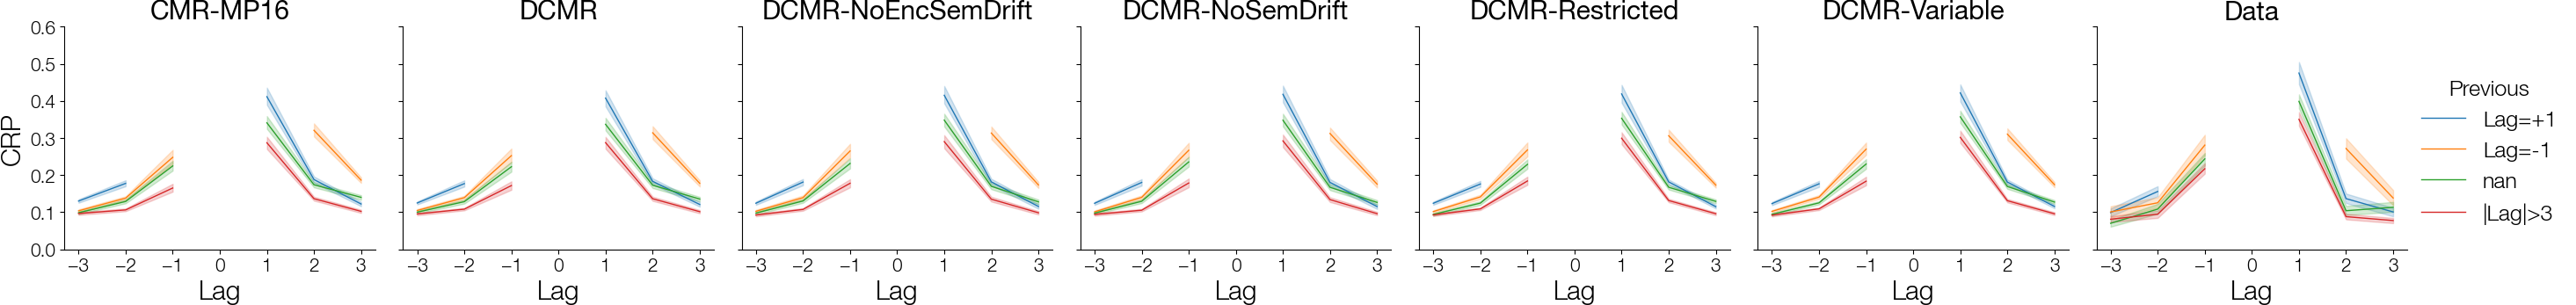

In [36]:
g = fr.plot_lag_crp(
    summed, lag_key='current', hue='Previous', col='source', height=4, max_lag=3
).add_legend()
g.set_titles(template='{col_name}')
g.set(ylim=[0, 0.6], xticks=[-3, -2, -1, 0, 1, 2, 3])
g.savefig(fig_dir / 'lag_crp_compound.pdf');

### Test for compound cuing in data

In [37]:
subs = summed.loc['Data']
p1 = subs.loc[:, 'Lag=+1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(p1[['prob']].query('current == 1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,9.92118,125,two-sided,1.827842e-17,"[0.1, 0.15]",0.883849,3.079e+14,1.0


In [38]:
n1 = subs.loc[:, 'Lag=-1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(n1[['prob']].query('current == -1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.998669,125,two-sided,0.000002,"[0.04, 0.09]",0.445317,6970.418,0.99865


### Test for compound cuing in DCMR-Restricted

In [39]:
subs = summed.loc['DCMR-Restricted']
p1 = subs.loc[:, 'Lag=+1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(p1[['prob']].query('current == 1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,23.331803,125,two-sided,2.235283e-47,"[0.11, 0.13]",2.078562,8.594e+43,1.0


In [40]:
n1 = subs.loc[:, 'Lag=-1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(n1[['prob']].query('current == -1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,17.494891,125,two-sided,2.104531e-35,"[0.07, 0.09]",1.558569,1.289e+32,1.0


In [41]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.24.0

numpy     : 1.26.4
pandas    : 2.1.4
scipy     : 1.13.0
seaborn   : 0.13.2
cymr      : 0.12.1
dcmr      : 0.1.0
mindstorm : 0.11.1
matplotlib: 3.9.0
psifr     : 0.9.2
pingouin  : 0.5.4

